In [1]:
import pandas as pd
from pathlib import Path
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
import osmnx as ox
from shapely.geometry import Polygon
from IPython.display import display
import ipywidgets as widgets
from ipywidgets import interact
import warnings
from scipy.spatial.distance import cdist
from collections import Counter
import plotly.express as px
import plotly.graph_objects as go

token = "pk.eyJ1IjoicGFibG9nYXNjbyIsImEiOiJjbHN0MHloeGwweGwzMmtxaXFobDNwc29tIn0.cXi2ESWBKoAPywLexpqruQ"

warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
def calculate_distance(df):
    # Radius of the Earth in kilometers
    r = 6371.0

    # Convert degrees to radians
    lat1 = np.radians(df['latitude'])
    lon1 = np.radians(df['longitude'])
    lat2 = np.radians(df['home_lat'])
    lon2 = np.radians(df['home_lon'])

    # Differences
    dlon = lon2 - lon1
    dlat = lat2 - lat1

    # Haversine formula
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

    # Distance in kilometers between the points on the sphere
    distance_sphere = r * c

    # Difference in elevation between the points
    delev = df['elevation']

    # Euclidean distance
    distance = np.sqrt(distance_sphere**2 + delev**2)

    return distance

In [3]:
# Load the dataframe outside the function
data_dir = Path("/data/pgcasado/datasets/acute/")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    df = pd.concat(
        pd.read_parquet(parquet_file)
        for parquet_file in data_dir.glob('*.parquet')
    )

mask = (df['timestamp'] > '2023-06-21') & (df['timestamp'] <= '2023-12-31') & (df["station_name"] == "0QRDKC2R03J32P") & (df["latitude"] > 3)
df = df[mask] # Create a copy to avoid SettingWithCopyWarning
df['distance'] = df.apply(calculate_distance, axis=1)

def plot_clusters(altitude_limit, eps, min_samples, selected_tags):
    
    global df  # Use the global df inside the function
    
    # Filter by altitude
    mask_alt = (df["altitude"] > altitude_limit)
    df_filtered_mask = df.loc[mask_alt].copy()
    
    # Define your latitude and longitude limits
    lat_min, lat_max = df_filtered_mask["latitude"].min(), df_filtered_mask["latitude"].max()
    lon_min, lon_max = df_filtered_mask["longitude"].min(), df_filtered_mask["longitude"].max()

    # Create a square polygon
    polygon = Polygon([(lon_min, lat_min), (lon_min, lat_max), (lon_max, lat_max), (lon_max, lat_min)])

    # Create the dataframe of the place of interest
    #tags = {"building": ["church", "palace", "chapel", "university", "hospital", "government", "stadium", "historic"], "amenities"}
     # Convert selected_tags to a dictionary
    tags = {tag.split(": ")[0]: [tag.split(": ")[1]] for tag in selected_tags}
    dfx = ox.features.features_from_polygon(polygon, tags= tags).copy()  # Create a copy to avoid SettingWithCopyWarning
    dfx.dropna(subset=['name'], inplace=True)
    dfx['longitude'] = dfx['geometry'].apply(lambda x: x.centroid.coords.xy[0][0])
    dfx['latitude'] = dfx['geometry'].apply(lambda x: x.centroid.coords.xy[1][0])

    # Read the shapefile for the world map
    warnings.filterwarnings("ignore")
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

    # Plot the world map
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        world.plot(color='white', edgecolor='black')

    # Create a DBSCAN object with the updated parameters
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the model to the data
    dbscan.fit(df_filtered_mask[['latitude', 'longitude']])
    df_filtered_mask["cluster"] = dbscan.labels_

    dfn = df_filtered_mask[df_filtered_mask["cluster"] >= 0]
    labels = np.delete(dbscan.labels_, np.where(dbscan.labels_ == -1))

    # Plot the clusters
    plt.scatter(dfn['longitude'], dfn['latitude'], c=labels, cmap="tab10", marker=".")

    # Add the cluster labels to the plot
    for i in range(len(np.unique(labels))):
        x = np.mean(dfn[dfn["cluster"] == i]['longitude'])
        y = np.mean(dfn[dfn["cluster"] == i]['latitude'])
        plt.annotate(str(i), xy=(x, y), color='black', fontsize=12, fontweight='bold', ha='center', va='center')

    # Set the x and y limits of the plot
    plt.xlabel("longitude")
    plt.ylabel("latitude")
    plt.xlim(dfn["longitude"].min()-0.01, dfn["longitude"].max()+0.01)
    plt.ylim(dfn["latitude"].min()-0.01, dfn["latitude"].max()+0.01)

    plt.scatter(df_filtered_mask["station_longitude"].iloc[0], df_filtered_mask["station_latitude"].iloc[0], marker="+", color="black")
    plt.scatter(dfx["longitude"].values, dfx["latitude"].values, marker=".", color="black", s = 2)

    # Show the plot
    plt.show()
    
    cluster_df = pd.DataFrame()
    for i in range(df_filtered_mask["cluster"].max()):
        df_i = df_filtered_mask[df_filtered_mask["cluster"]==i]
        cluster_df.loc[i, "nº detection"] = df_i.shape[0]
        cluster_df.loc[i, "max_altitude"] = df_i["altitude"].max()
        cluster_df.loc[i, "std_altitude"] = round(df_i["altitude"].std(), 2)
        cluster_df.loc[i, "mean_altitude"] = round(df_i["altitude"].mean(), 2)
        cluster_df.loc[i, "max_distance"] = round(df_i["distance"].max(),2)
        cluster_df.loc[i, "std_distance"] = round(df_i["distance"].std(),2)
        cluster_df.loc[i, "mean_distance"] = round(df_i["distance"].mean(),2)
        cluster_df.loc[i, "main model"] = df_i["model"].value_counts().idxmax()
        cluster_df.loc[i, "nº model"] = len(df_i["model"].unique())
        cluster_df.loc[i, "nº ID"] = len(df_i["ident"].unique())
        cluster_df.loc[i, "nº days"] = pd.to_datetime(df_i['timestamp']).dt.date.nunique()

    cluster_df["nº detection"] = cluster_df["nº detection"].astype("int")
    cluster_df["nº ID"] = cluster_df["nº ID"].astype("int")
    cluster_df["nº days"] = cluster_df["nº days"].astype("int")
    cluster_df["nº model"] = cluster_df["nº model"].astype("int")
    display(cluster_df)

# Use interact to create interactive sliders
# Use interact to create interactive sliders
interact(
    plot_clusters,
    altitude_limit=widgets.FloatSlider(min=0, max=500, step=10, value=0, description='Altitude Limit'),
    eps=widgets.FloatSlider(min=0.001, max=0.2, step=0.001, value=0.025, description='Eps'),
    min_samples=widgets.IntSlider(min=1, max=50, step=1, value=17, description='Min Samples'),
    selected_tags=widgets.SelectMultiple(options=["building: church", "building: chapel", "building: university", "building: hospital", "building: government", "building: stadium", "amenities: prison", "amenities: police"],
                                         value=["building: university",], description='Tags')
)


interactive(children=(FloatSlider(value=0.0, description='Altitude Limit', max=500.0, step=10.0), FloatSlider(…

<function __main__.plot_clusters(altitude_limit, eps, min_samples, selected_tags)>

In [4]:
# Load the dataframe outside the function
data_dir = Path("/data/pgcasado/datasets/acute/")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    df = pd.concat(
        pd.read_parquet(parquet_file)
        for parquet_file in data_dir.glob('*.parquet')
    )

mask = (df['timestamp'] > '2023-06-21') & (df['timestamp'] <= '2023-12-31') & (df["station_name"] == "0QRDKC2R03J32P") & (df["latitude"] > 3)
df = df[mask] # Create a copy to avoid SettingWithCopyWarning
df['distance'] = df.apply(calculate_distance, axis=1)

def plot_clusters(altitude_limit, eps, min_samples, selected_tags):
    
    global df  # Use the global df inside the function
    
    # Filter by altitude
    mask_alt = (df["altitude"] > altitude_limit)
    df_filtered_mask = df.loc[mask_alt].copy()
    
    # Define your latitude and longitude limits
    lat_min, lat_max = df_filtered_mask["latitude"].min(), df_filtered_mask["latitude"].max()
    lon_min, lon_max = df_filtered_mask["longitude"].min(), df_filtered_mask["longitude"].max()

    # Create a square polygon
    polygon = Polygon([(lon_min, lat_min), (lon_min, lat_max), (lon_max, lat_max), (lon_max, lat_min)])

    # Create the dataframe of the place of interest
    #tags = {"building": ["church", "palace", "chapel", "university", "hospital", "government", "stadium", "historic"], "amenities"}
     # Convert selected_tags to a dictionary
    tags = {tag.split(": ")[0]: [tag.split(": ")[1]] for tag in selected_tags}
    dfx = ox.features.features_from_polygon(polygon, tags= tags).copy()  # Create a copy to avoid SettingWithCopyWarning
    dfx.dropna(subset=['name'], inplace=True)
    dfx['longitude'] = dfx['geometry'].apply(lambda x: x.centroid.coords.xy[0][0])
    dfx['latitude'] = dfx['geometry'].apply(lambda x: x.centroid.coords.xy[1][0])


    warnings.filterwarnings("ignore")
    # Create a DBSCAN object with the updated parameters
    dbscan = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the model to the data
    dbscan.fit(df_filtered_mask[['latitude', 'longitude']])
    df_filtered_mask["cluster"] = dbscan.labels_

    dfn = df_filtered_mask[df_filtered_mask["cluster"] >= 0]
    labels = np.delete(dbscan.labels_, np.where(dbscan.labels_ == -1))

    # Assuming df1 and df2 are your dataframes
    fig = px.scatter_mapbox(dfn, lat='latitude', lon='longitude', color='cluster',
                        zoom=10, height=1000, width=1500,
                        title='Drone Detected Position')

    # Add scatter_mapbox trace for df2
    fig.add_trace(go.Scattermapbox(
        lat=dfx['latitude'],
        lon=dfx['longitude'],
        mode='markers',
        marker=dict(size=10, color='white'),
        name='dfx'
    ))

    fig.update_layout(
        mapbox_style="dark",
        mapbox_accesstoken=token,
        margin={"r":0,"t":0,"l":0,"b":0},
        autosize=True,
        hovermode='closest',
        showlegend=True
    )

    fig.show()
    
    cluster_df = pd.DataFrame()
    for i in range(df_filtered_mask["cluster"].max()):
        df_i = df_filtered_mask[df_filtered_mask["cluster"]==i]
        cluster_df.loc[i, "nº detection"] = df_i.shape[0]
        cluster_df.loc[i, "max_altitude"] = df_i["altitude"].max()
        cluster_df.loc[i, "std_altitude"] = round(df_i["altitude"].std(), 2)
        cluster_df.loc[i, "mean_altitude"] = round(df_i["altitude"].mean(), 2)
        cluster_df.loc[i, "max_distance"] = round(df_i["distance"].max(),2)
        cluster_df.loc[i, "std_distance"] = round(df_i["distance"].std(),2)
        cluster_df.loc[i, "mean_distance"] = round(df_i["distance"].mean(),2)
        cluster_df.loc[i, "main model"] = df_i["model"].value_counts().idxmax()
        cluster_df.loc[i, "nº model"] = len(df_i["model"].unique())
        cluster_df.loc[i, "nº ID"] = len(df_i["ident"].unique())
        cluster_df.loc[i, "nº days"] = pd.to_datetime(df_i['timestamp']).dt.date.nunique()

    cluster_df["nº detection"] = cluster_df["nº detection"].astype("int")
    cluster_df["nº ID"] = cluster_df["nº ID"].astype("int")
    cluster_df["nº days"] = cluster_df["nº days"].astype("int")
    cluster_df["nº model"] = cluster_df["nº model"].astype("int")
    display(cluster_df)

# Use interact to create interactive sliders
# Use interact to create interactive sliders
interact(
    plot_clusters,
    altitude_limit=widgets.FloatSlider(min=0, max=500, step=10, value=0, description='Altitude Limit'),
    eps=widgets.FloatSlider(min=0.001, max=0.2, step=0.001, value=0.025, description='Eps'),
    min_samples=widgets.IntSlider(min=1, max=50, step=1, value=17, description='Min Samples'),
    selected_tags=widgets.SelectMultiple(options=["building: church", "building: chapel", "building: university", "building: hospital", "building: government", "building: stadium", "amenities: prison", "amenities: police"],
                                         value=["building: university",], description='Tags')
)

interactive(children=(FloatSlider(value=0.0, description='Altitude Limit', max=500.0, step=10.0), FloatSlider(…

<function __main__.plot_clusters(altitude_limit, eps, min_samples, selected_tags)>

/tmp/ipykernel_1208903/3061463278.py:33: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



76


(50.56199478149414, 51.385995635986326)

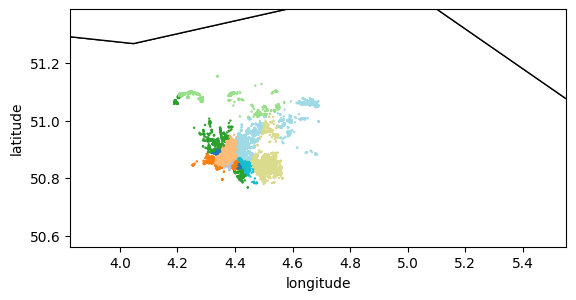

In [5]:
data_dir = Path("/data/pgcasado/datasets/acute/")
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=FutureWarning)
    df2 = pd.concat(
        pd.read_parquet(parquet_file)
        for parquet_file in data_dir.glob('*.parquet')
    )
    
mask = (df2['timestamp'] > '2023-06-21') & (df2['timestamp'] <= '2023-12-31') & (df2["station_name"] == "0QRDKC2R03J32P")
df2 = df2[mask] # Create a copy to avoid SettingWithCopyWarning

altitude_limit = 50
mask_alt = (df2["altitude"] > altitude_limit)
df2 = df2.loc[mask_alt]

# Define your latitude and longitude limits
lat_min, lat_max = df2["latitude"].min(), df2["latitude"].max()
lon_min, lon_max = df2["longitude"].min(), df2["longitude"].max()

# Create a square polygon
polygon = Polygon([(lon_min, lat_min), (lon_min, lat_max), (lon_max, lat_max), (lon_max, lat_min)])

# Create the dataframe of the place of interest
#tags = {"building": ["church", "palace", "chapel", "university", "hospital", "government", "stadium", "historic"]}
tags = {"building":["university",]}
dfx = ox.features.features_from_polygon(polygon, tags=tags)

dfx.dropna(subset=['name'], inplace=True)
dfx['longitude'] = dfx['geometry'].apply(lambda x: x.centroid.coords.xy[0][0])
dfx['latitude']  = dfx['geometry'].apply(lambda x: x.centroid.coords.xy[1][0])

# read the shapefile for the world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# plot the world map
world.plot(color='white', edgecolor='black')

# Calculate the distance between each point and each centroid
centroids = dfx[["latitude", "longitude"]].to_numpy()
points = df2[["latitude", "longitude"]].to_numpy()
distances = cdist(points, centroids, "euclidean")
min_distances = np.min(distances, axis=1)

# Remove those points which are further than MaxDist
#MaxDist = 0.5
#distances = distances[min_distances < MaxDist]
#points    = points[min_distances < MaxDist, :]

# Find the index of the closest centroid for each point
clusters = np.argmin(distances, axis=1)

# Remove those clusters with less than N values
N = 300
counter = Counter(clusters)
print(len(counter))
df2["clusters"] = [-1 if counter[i] < N else i for i in clusters]
dfn = df2[df2["clusters"] >= 0]
labels = [i for i in df2["clusters"] if i != -1]

# plot the clusters
plt.scatter(dfn['longitude'], dfn['latitude'], c=labels, cmap = "tab20", marker=".", s=2)

# set the x and y limits of the plot
plt.xlabel("longitude")
plt.ylabel("latitude")
plt.xlim(df2["longitude"].min()-0.01, df2["longitude"].max()+0.01)
plt.ylim(df2["latitude"].min()-0.01, df2["latitude"].max()+0.01)


In [6]:
# Assuming df is your DataFrame
dictionary = dfx.droplevel(level=1)["name"].reset_index().set_index("name").squeeze().to_dict()
sorted_dict = dict(sorted(dictionary.items()))

In [7]:
for a, b in sorted_dict.items():
    if len(a) > 2:
        print(a, b)

200A - Computerwetenschappen way
200B - Instituut voor Wiskunde way
200C - Kandidatuur Natuurkunde way
200D - Instituut Natuurkunde navorsing relation
200E - Geo-instituut way
200F - Chem&Tech way
200G - Kandidatuur Scheikunde way
200H - Quadrivium way
200I - Monitoraten way
Administratief en Logistiek gebouw relation
Afvalgebouw way
Amfitheater relation
Antwerp Management School node
Arenbergkasteel way
Arlon 14 way
Atelier de dessin way
Auditoire André Simonart way
Auditoire Paul-Emile Janson way
Auditoires Agora way
Auditoires Croix du Sud way
Auditoires Montesquieu way
Auditoires Pierre de Coubertin way
Auditoires centraux way
Auditoires des Sciences way
Auditoria 200K way
Auditoria 200L way
Auditoria 200M way
Auditoria 200N way
Auditoria J.Monnet-M.Weber way
Auditoriacomplex way
Auditorium Bouckaert way
Auditorium Oude Molen way
Bergplaats way
Bergplaats Alma way
Bibliothèque des Sciences et Technologies way
Bio-incubator 1 way
Biomed 2 way
Biosystemen I way
Bodemkundige Dienst va

In [8]:
import plotly.express as px

token = "pk.eyJ1IjoicGFibG9nYXNjbyIsImEiOiJjbHN0MHloeGwweGwzMmtxaXFobDNwc29tIn0.cXi2ESWBKoAPywLexpqruQ"

fig = px.scatter_mapbox(df2, lat='latitude',lon='longitude', 
                        
                        zoom=10, color="clusters",

                        color_discrete_sequence=['fuchsia'],

                        height=1000, width=1500,

                        title='Drone Detected Position')

fig.update_layout(mapbox_style="dark", mapbox_accesstoken=token)

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})

fig.show()